<a href="https://colab.research.google.com/github/RuslanMavlitov/sf_data_science/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22hometask_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мини-проект. Практика. Ядерные функции


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Мы выступим в роли программиста-сомелье: нам предстоит определять качество вина. Необходимо решить задачу классификации с использованием SVM и подобрать наилучшее ядро.


## Загрузка данных

In [8]:
data = pd.read_csv('/content/drive/MyDrive/SF/data/winequality-red.zip', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Нет пропусков, все признаки количественные (тип "float64"). 




In [10]:
# Сделаем небольшие преобразования в датасете
data.columns = data.columns.str.replace(' ', '_')

#Сделаем целевую переменную категориальной ('bad wine': quality < 6.5 и 'good wine': quality > 6.5)
data['quality'] =  data.quality.apply(lambda x: 'good wine' if x>6.5 else 'bad wine')

#Закодируем целевую переменную.
data['quality'] =  data.quality.apply(lambda x: 1 if x=='good wine' else 0)

data['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

Что-то маловато хорошего вина. Оставим целевой признак таким и перейдем к анализу и обработке признаков

## Анализ данных


Пройдемся по признакам...

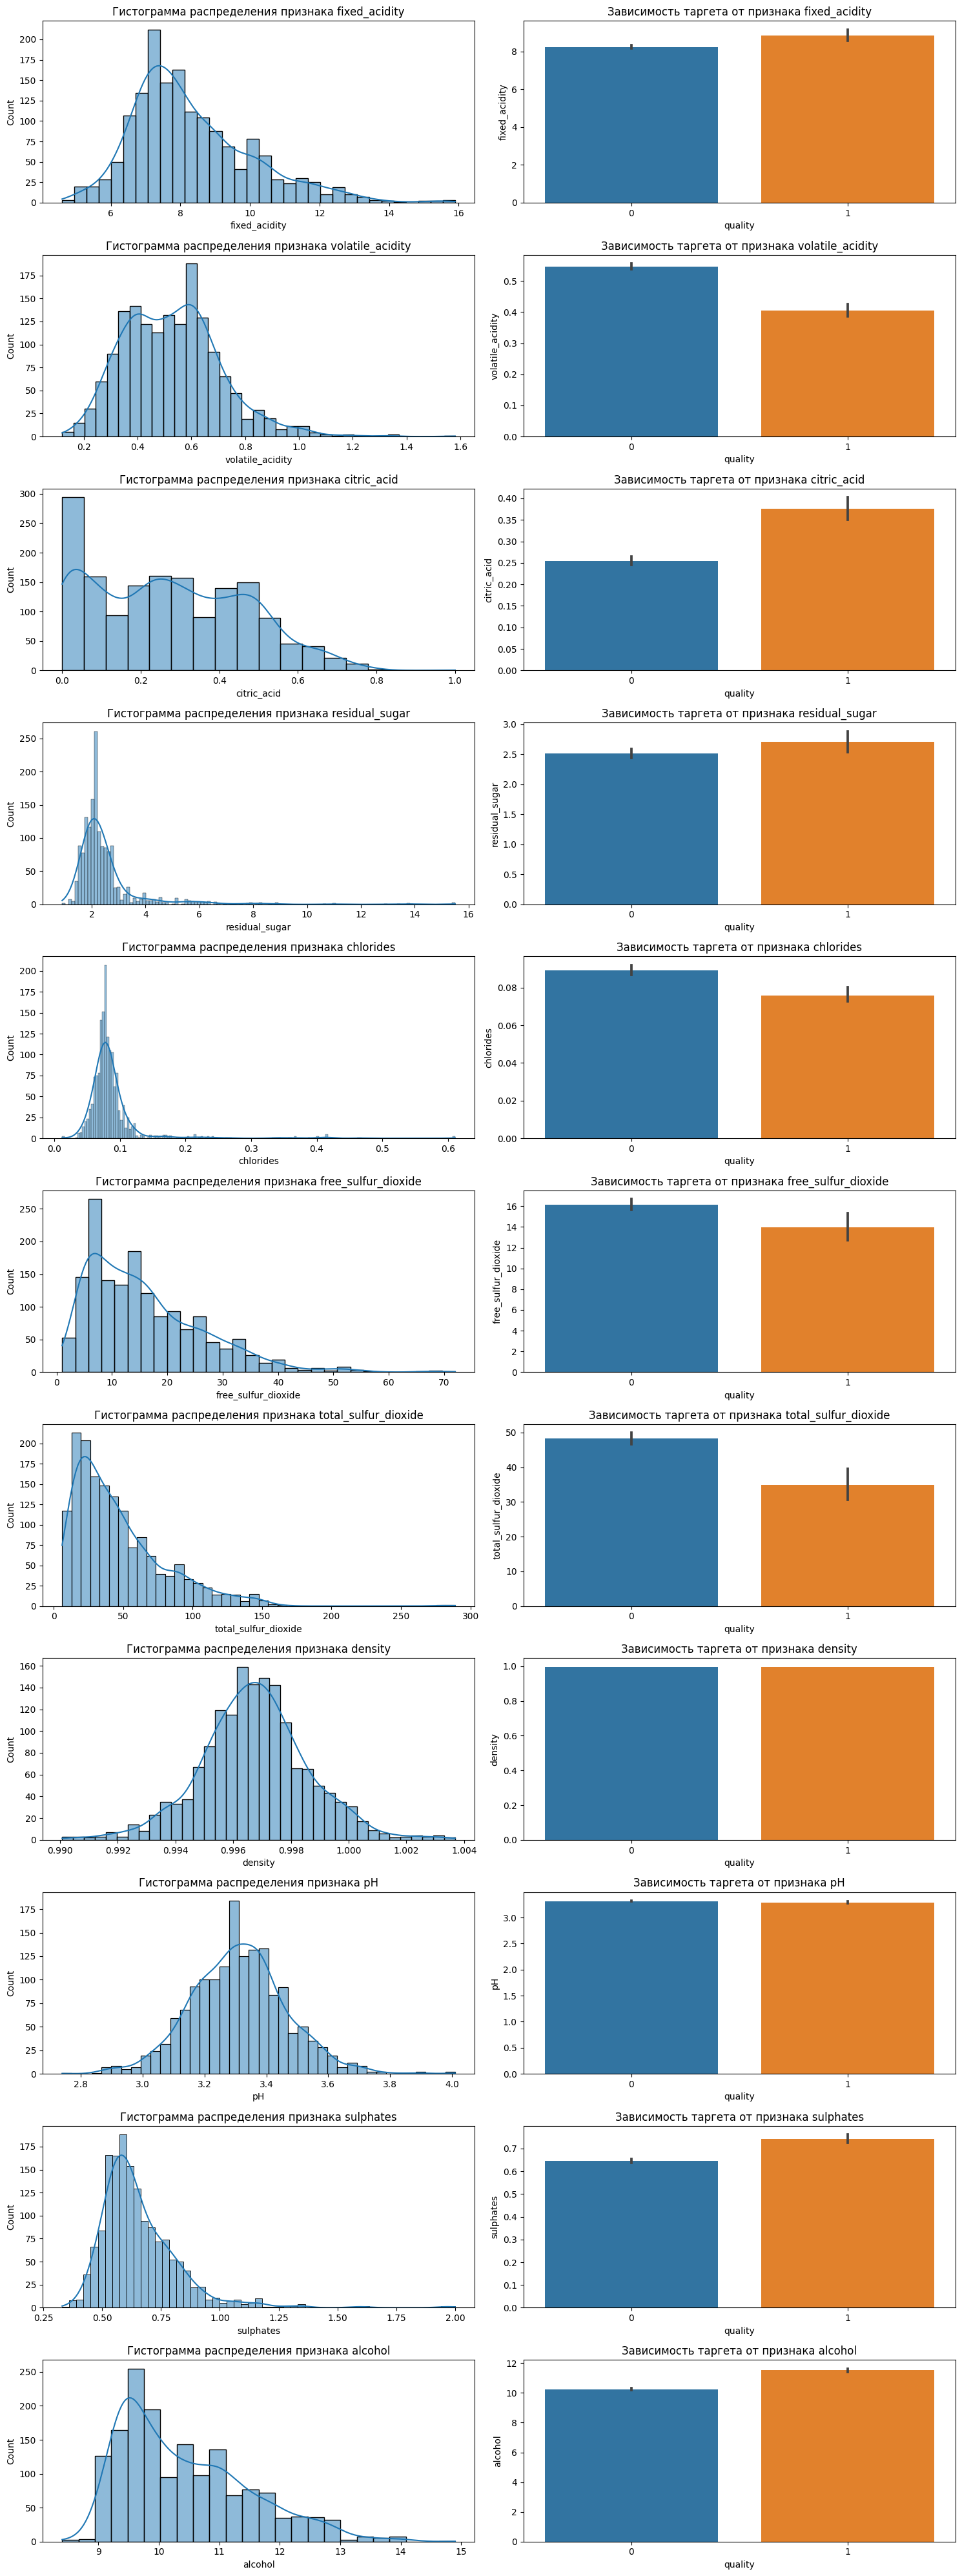

In [17]:
features = list(data.columns)
features.remove('quality')

n = len(features) #число признаков
fig, ax = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка признаков
for i, feature in enumerate(features):
    #Строим гистограмму распределения признака
    ax[i][0].set_title(f'Гистограмма распределения признака {feature}')
    sns.histplot(data=data, x=feature, ax=ax[i][0], kde=True)
    #Строим график зависимости зарплаты от признака (среднее значение)
    ax[i][1].set_title(f'Зависимость таргета от признака {feature}')
    sns.barplot(data = data, y=feature, x='quality', ax=ax[i][1])

plt.tight_layout() #выравнивание графиков

## Преобразования признаков.


In [18]:
#Разделим данные на признаки (Х) и таргет (Y)
X = data.drop(['quality'], axis=1)
Y = data['quality']

#преобразуем данные в признаках к единому масштабу, так как методы SVM чувствительны к масштабам признаков
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Поиск гипперпараметров SVM модели

In [19]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
kernel_range=['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(kernel=kernel_range, C = C_range, gamma = gamma_range)
model = SVC()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy',cv=cv,n_jobs=-1)
grid_search.fit(X, Y)
print(grid_search.best_params_)
print(grid_search.best_score_)

KeyboardInterrupt: ignored

Три часа подбирались параметры, просто не выдержал ожидание. Упростим решетку гиперпараметров.

In [20]:
C_range = np.logspace(-2, 5, 8)
gamma_range = np.logspace(-9, 3, 13)
kernel_range=['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C = C_range, gamma = gamma_range)
model = SVC()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy',cv=cv,n_jobs=-1)
grid_search.fit(X, Y)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10.0, 'gamma': 1.0}
0.9125


## Обучение модели с лучшими параметрами

In [37]:
from sklearn.model_selection import cross_val_score, cross_validate

svc = SVC(kernel='rbf', C=10,gamma=1, probability=True)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)

scores = cross_val_score(svc, X, Y, cv=cv, scoring='accuracy')
print(f'Точность модели на кросс-валидации с ядром "rbf" равна {scores.mean()}')

Точность модели на кросс-валидации с ядром "rbf" равна 0.9125


In [39]:
from sklearn.model_selection import cross_val_score, cross_validate

svc = SVC(kernel='linear', C=10,gamma=1, probability=True)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=42)

scores = cross_val_score(svc, X, Y, cv=cv, scoring='accuracy')
print(f'Точность обычной линейной модели SVM на кросс-валидации равна {scores.mean()}')

Точность обычной линейной модели SVM на кросс-валидации равна 0.866875


## Нахождение confusion matrix 

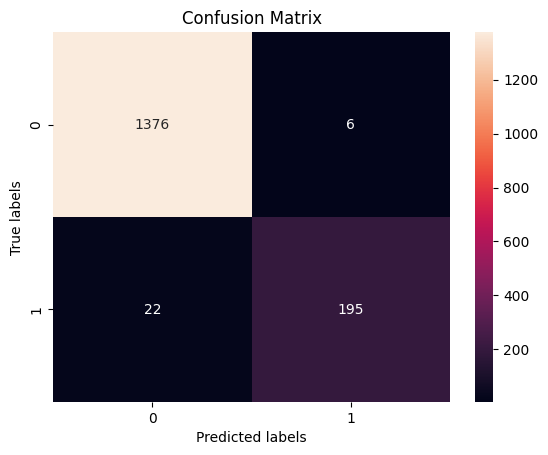

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

svc.fit(X_train, y_train)
y_pred = svc.predict(X)
cm = confusion_matrix(Y, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Вывод: Точность очень высокая у модели опорных векторов c RBF(ЯДРО РАДИАЛЬНОЙ БАЗИСНОЙ ФУНКЦИИ) показало гораздо лучше результат, чем обычное линейное разделение.
